In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy import integrate


In [2]:
# 数据读取
file_name1 = "Data/BAOData.txt"
dataB=np.loadtxt(file_name1, skiprows=1, usecols = (1,2,3), dtype=np.float32)
file_name2 = "Data/SNIaData.txt"
dataS=np.loadtxt(file_name2, skiprows=0, usecols = (4,6,7), dtype=np.float32)
file_name3 = "Data/ChronometersData.txt"
dataH=np.loadtxt(file_name3, skiprows=0, usecols = (0,1,2), dtype=np.float32)

In [3]:
# 将数据放入变量
xS=dataS[:,0]
xB=dataB[:,0]
xH=dataH[:,0]
yS=dataS[:,1]
yB=dataB[:,1]
yH=dataH[:,1]
yerrS=dataS[:,2]
yerrB=dataB[:,2]
yerrH=dataH[:,2]

# DESI数据
z_DV = np.array([0.30, 1.49])  # D_V的红移
z_DM = np.array([0.51, 0.71, 0.93, 1.32, 1.49, 2.33])  # D_M的红移
z_DH = np.array([0.51, 0.71, 0.93, 1.32, 2.33])  # D_H的红移

# 观测值
D_V_obs = np.array([7.93, 26.07])  # D_V
D_M_obs = np.array([13.62, 16.85, 21.71, 27.79, 26.07, 39.71])  # D_M
D_H_obs = np.array([20.98, 20.08, 17.88, 13.82, 8.52])  # D_H

# 误差（标准差）
sigma_DV = np.array([0.15, 0.67])  # D_V的误差
sigma_DM = np.array([0.25, 0.32, 0.28, 0.69, 0.67, 0.94])  # D_M的误差
sigma_DH = np.array([0.61, 0.60, 0.35, 0.42, 0.17])  # D_H的误差

# SDSS 数据
# D_V 数据
z_DV_SDSS = np.array([0.106, 0.15])  # D_V的红移
D_V_obs_SDSS = np.array([2.98, 4.51])  # D_V的观测值
sigma_DV_SDSS = np.array([0.13, 0.14])  # D_V的误差

# D_M 数据
z_DM_SDSS = np.array([0.38, 0.51, 0.70, 0.85, 1.48, 2.33, 2.33])  # D_M的红移
D_M_obs_SDSS = np.array([10.27, 13.38, 17.65, 19.50, 30.21, 37.60, 37.30])  # D_M的观测值
sigma_DM_SDSS = np.array([0.15, 0.18, 0.30, 1.00, 0.79, 1.90, 1.70])  # D_M的误差

# D_H 数据
z_DH_SDSS = np.array([0.38, 0.51, 0.70, 0.85, 1.48, 2.33, 2.33])  # D_H的红移
D_H_obs_SDSS = np.array([24.89, 22.43, 19.78, 19.60, 13.23, 8.93, 9.08])  # D_H的观测值
sigma_DH_SDSS = np.array([0.58, 0.48, 0.46, 2.10, 0.47, 0.28, 0.34])  # D_H的误差

with open('Data/Pantheon+SH0ES_STAT+SYS.cov', 'r') as f:
    lines = f.readlines()
N = int(lines[0].strip())
cov_elements = np.array([float(x.strip()) for x in lines[1:]])
cov_full = cov_elements.reshape((N, N))
cov_inv = np.linalg.inv(cov_full)

In [4]:
# 常数
c_light=3e5

In [5]:
# 定义哈勃参数 H(z)
def H(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    term1 = c**2 * wde + 2 * c**2 * wde * a
    term2 = (1 + z)**(3 * (1 + a) / (4 + 6 * a))
    sqrt_inner = H0 / m**2 + c**4 * (wde + 2 * wde * a)**2 + 2 * np.sqrt(c**4 * H0 / m**2 * (wde + 2 * wde * a)**2)
    H = term1 + term2 * np.sqrt(sqrt_inner)**2*m**2
    return H

def InvEz(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    return H0/H(z, theta)

def InteEz(z, theta):
    Inte = []
    for zi in z:
        if zi > 0:
            # 直接使用quad进行快速积分
            fArea, _ = integrate.quad(InvEz, 0, zi, args=(theta))
            Inte.append(fArea)
        else:
            Inte.append(0)
    return np.array(Inte)

# def InteEz(z, theta):
#     datadim = len(z)
#     steplength = 0.001
#     Inte = []
#     for i in range(datadim):
#         xe = float(z[i])
#         if xe >= 0:
#             # 生成 z 数组
#             zi = np.arange(0, xe + steplength, steplength)
#             # 计算 invE (即1/Ez)
#             invE = InvEz(zi, theta)
#             # 使用 simpson 进行积分，正确传递参数
#             fArea = integrate.simpson(invE, x=zi)
#             Inte.append(fArea)
#         else:
#             continue
#     return np.array(Inte)

def D_L(z,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    d_z=(1+z)*c_light/H0*InteEz(z, theta)
    return d_z



# 定义距离尺度 D_M(z) 和 D_V(z)
def D_M(z, theta):
    H0, c, a, m, wde, Mb, r_d =theta
    return D_L(z,theta)/(1+z)/r_d

def D_V(z,theta):
    H0, c, a, m, wde, Mb, r_d =theta
    # 计算D_V(z) = (D_M^2 * z / H(z))^(1/3)
    D_m = D_M(z, theta)
    H_z = H(z, theta)
    return ((D_L(z,theta)/(1+z))**2 *c_light * z / H_z) ** (1/3) / r_d

def D_H(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    # 计算D_H(z) = c / H(z)
    H_z = H(z, theta)
    return c_light / H_z / r_d



In [6]:
def log_likelihood(theta):
    H0, c, a, m, wde, Mb, r_d= theta

    # H(z) data
    H_z=H(xH,theta)
    sigma2H = yerrH ** 2
    xiH=(yH -H_z) ** 2 / sigma2H
    ChiH=np.sum(xiH)
    # # BAO data
    # D_A=D_L(xB,theta)/(1+xB)
    # modelB=100*1.6*180/np.pi/D_A
    # sigma2B = yerrB ** 2
    # xiB=(yB - modelB) ** 2 / sigma2B
    # ChiB=np.sum(xiB)
    # SNe data
    modelS=5*np.log10(D_L(xS,theta))+25+Mb
    # sigma2S = yerrS ** 2
    # xiS=(yS - modelS) ** 2 / sigma2S
    # yiS=(yS - modelS) ** 1 / sigma2S
    # ziS=1.0 / sigma2S
    # XiS=np.sum(xiS)
    # YiS=np.sum(yiS)
    # ZiS=np.sum(ziS)
    # ChiS=XiS-YiS**2/ZiS+np.log10(ZiS/np.pi/2) 边缘化M_b
    XiS = (yS - modelS).T @ cov_inv @ (yS - modelS)

    # DESI
    # D_V的预测
    model_DV = D_V(z_DV, theta)
    chi2_DV = np.sum(((D_V_obs - model_DV) / sigma_DV) ** 2)
    # D_M的预测
    model_DM = D_M(z_DM, theta)
    chi2_DM = np.sum(((D_M_obs - model_DM) / sigma_DM) ** 2)
    # D_H的预测
    model_DH = D_H(z_DH, theta)
    chi2_DH = np.sum(((D_H_obs - model_DH) / sigma_DH) ** 2)
    # 总的Chi2
    ChiD=(chi2_DV + chi2_DM + chi2_DH)

    # BAO SDSS 6dF
    # D_V的预测
    model_DV_SDSS = D_V(z_DV_SDSS, theta)
    chi2_DV_SDSS = np.sum(((D_V_obs_SDSS - model_DV_SDSS) / sigma_DV_SDSS) ** 2)
    # D_M的预测
    model_DM_SDSS = D_M(z_DM_SDSS, theta)
    chi2_DM_SDSS = np.sum(((D_M_obs_SDSS - model_DM_SDSS) / sigma_DM_SDSS) ** 2)
    # D_H的预测
    model_DH_SDSS = D_H(z_DH_SDSS, theta)
    chi2_DH_SDSS = np.sum(((D_H_obs_SDSS - model_DH_SDSS) / sigma_DH_SDSS) ** 2)
    # 总的Chi2
    ChiD_SDSS=(chi2_DV_SDSS + chi2_DM_SDSS + chi2_DH_SDSS)
    return 0.5*(-ChiH-XiS-ChiD-ChiD_SDSS)

# 先验函数
def log_prior(theta):
    H0, c, a, m, wde, Mb, r_d = theta
    if 50 < H0 < 100 and -1.5<wde<-0.1 and -20<c<0 and -1<a<0 and -30<Mb<0 and -2<m<0 and 100<r_d<200 and (3 * (1 + a) / (4 + 6 * a))>=0:  # 对H0进行限制
    # if 67 < H0 < 75 and  -1.1<wde<-0.9  and 24<mu<27:
        return 0.0
    return -np.inf

# 后验函数
def log_probability(theta):
    lp = log_prior(theta)
    # if np.isnan(log_likelihood(theta)):
    #     print("nan number is found",theta)
    #     return -np.inf
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

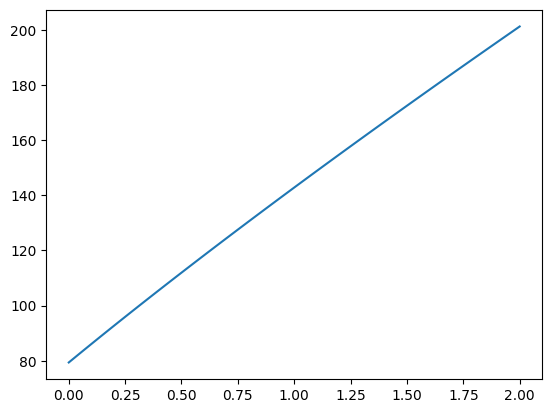

In [7]:
z = np.linspace(0, 2, 100,dtype=np.float32)
params=[70,-1,-0.18,-1,-0.9,-19,150]
plt.plot(z,H(z,params))
plt.show()

In [8]:
print(log_likelihood(params))

-1954.9286205752524


In [9]:
# 初始化参数
nwalkers = 70
ndim = 7
nstep=1000
# 假设参数的初始值和扰动标准差
initial_values = np.array([70, -1, -0.2, -1, -0.9, -19, 150])
std_devs = np.array([5, 1.0, 0.05, 0.05, 0.1, 0.05, 20])  # 对应每个参数的扰动大小
np.random.seed(42)  # 设置固定的随机种子

# 使用不同标准差生成扰动
p0 = initial_values + std_devs * np.random.randn(nwalkers, ndim)*1e-1


In [10]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

import emcee
from multiprocessing import Pool
import time


with Pool() as pool:
    start = time.time()
    # 设置emcee采样
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,pool=pool)
    sampler.run_mcmc(p0, nstep, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

64 CPUs


100%|██████████| 1000/1000 [36:49<00:00,  2.21s/it]

Multiprocessing took 2211.8 seconds


In [11]:
# 处理结果
samples = sampler.get_chain(discard=300, thin=50, flat=True)   
H0_median = np.median(samples[:, 0])
print(H0_median)
c_midian = np.median(samples[:, 1])
print(c_midian)
a_midian = np.median(samples[:, 2])
print(a_midian)
m_midian = np.median(samples[:, 3])
print(m_midian)
wde_midian = np.median(samples[:, 4])
print(wde_midian)
Mb_midian = np.median(samples[:, 5])
print(Mb_midian)
rd_midian = np.median(samples[:, 6])
print(rd_midian)

59.689342385687155
-1.1959314982125326
-0.34089311801416355
-1.1765071690000637
-0.5653900122970081
-19.48576678104988
146.42565189051192


In [12]:
rd_midian*H0_median/100

87.40050869740206

In [13]:
np.savetxt("Chains/MC_chainWithDESI_fQT_D=05.txt", samples ,fmt='%f',delimiter=',')

Removed no burn in


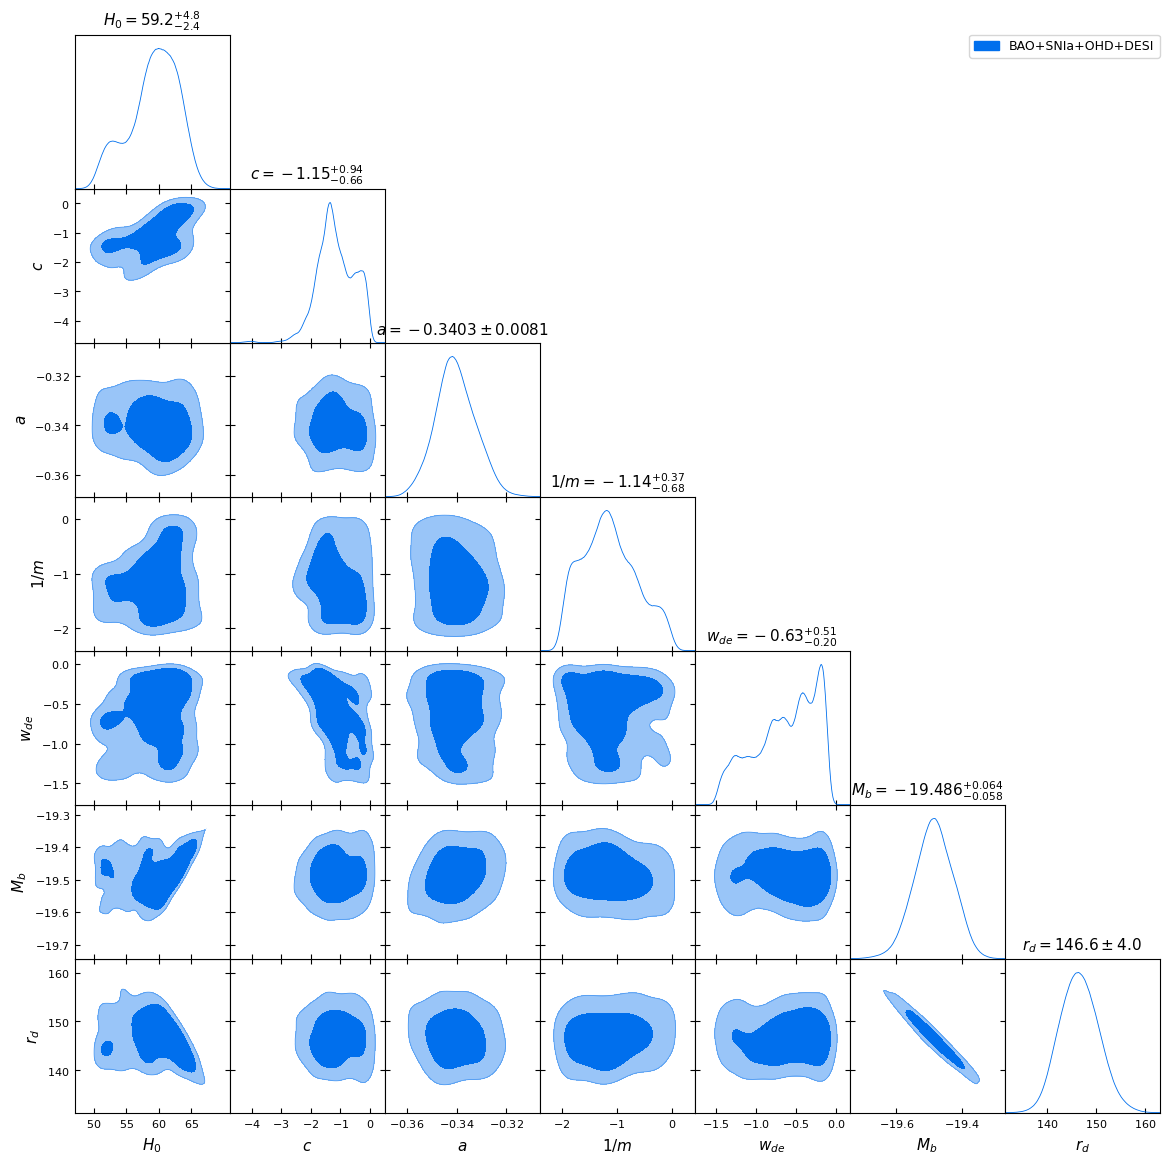

In [14]:
from getdist import plots, MCSamples
import getdist
%matplotlib inline
labels= ['H_0','c','a','1/m','w_{de}','M_b','r_d']
names = ['H_0','c','a','1/m','w_{de}','M_b','r_d']
samplesplot = MCSamples(samples=samples,names =names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot(samplesplot , filled=True, legend_labels=['BAO+SNIa+OHD+DESI', 'Simulation 2'], 
    legend_loc='upper right',title_limit=1)

# plt.savefig('./pic/getdist.pdf', format='pdf')
plt.show()

[]

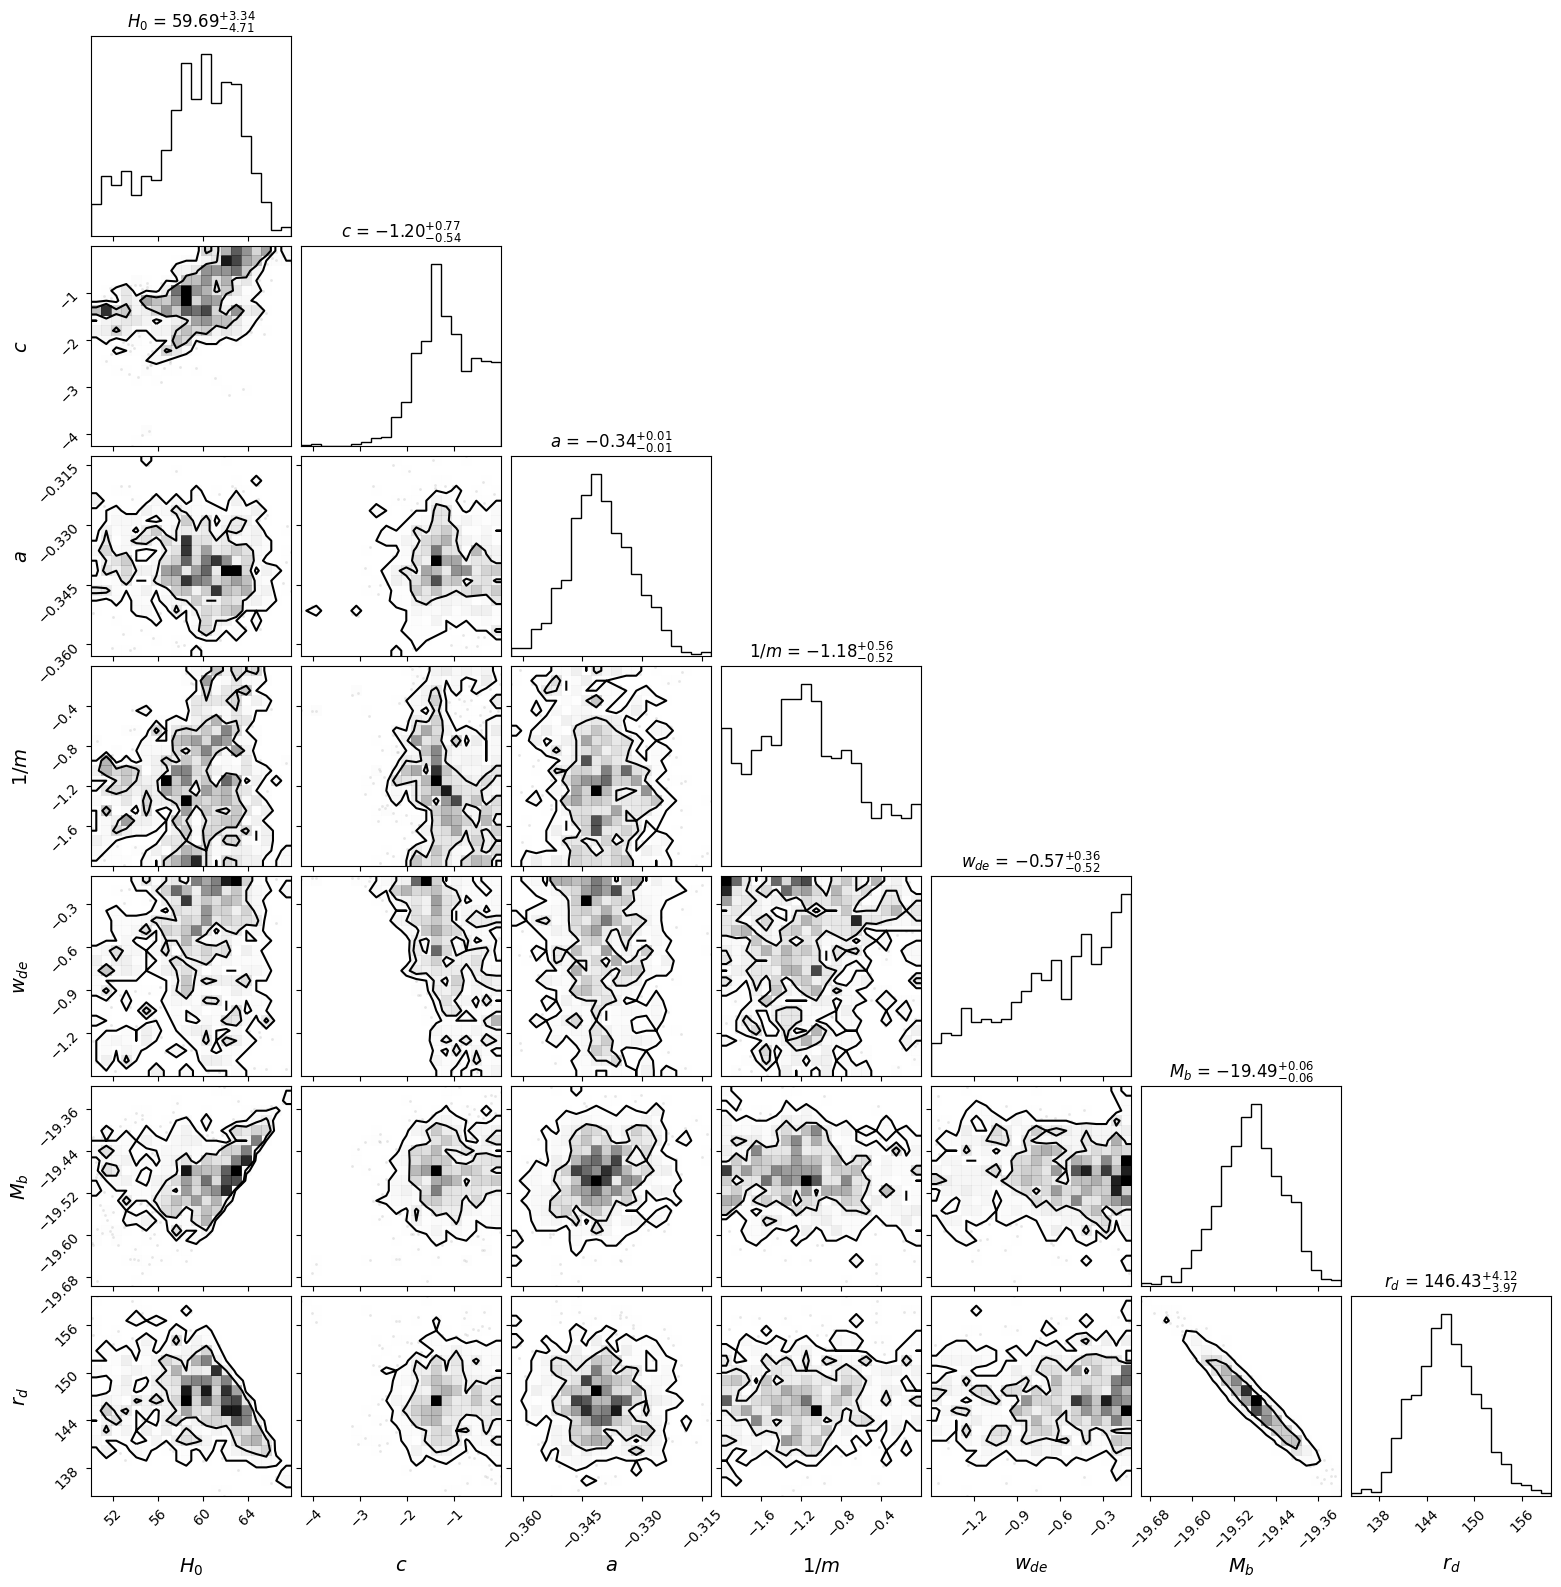

In [15]:
import corner

# 绘制一个定制的corner图
corner.corner(samples,
              labels= ['$H_0$','$c$','$a$','$1/m$','$w_{de}$','$M_b$','$r_d$'],
              fill=True,             # 填充颜色
              levels=[0.68, 0.95],   # 显示68%、95%的置信区间
              show_titles=True,      # 显示标题
              title_kwargs={"fontsize": 12},
              label_kwargs={"fontsize": 14})
# plt.savefig('./pic/corner.pdf', format='pdf')
plt.plot()


/tmp/ipykernel_8900/1775792201.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(samples_all[:,:,i], "k", color='black',alpha=0.3)


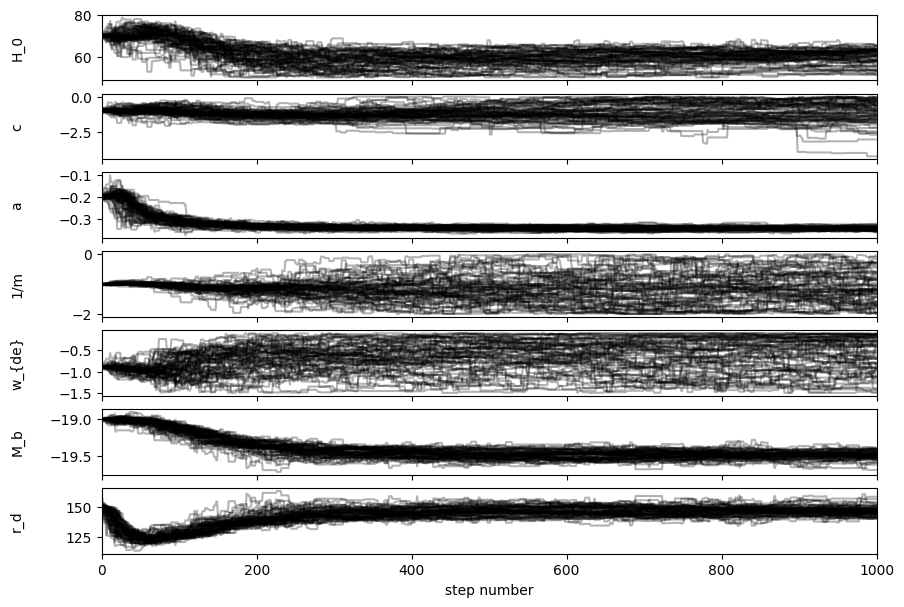

In [16]:
samples_all = sampler.get_chain()


fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
#samples = np.loadtxt(file_name, delimiter=',', skiprows=0, dtype=np.float32)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:,:,i], "k", color='black',alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [17]:
# 处理结果
theta_median = [] 
for n in range(ndim):
    theta_median.append(np.mean(samples[:,n]))
print(theta_median)

[59.20899915713643, -1.1481382578258064, -0.340340126778276, -1.1424706886842966, -0.6260933805711189, -19.48608709372778, 146.55056536344577]


In [18]:
print(samplesplot.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $59.2^{+6.1}_{-8.1}        $\\

{\boldmath$c              $} & $-1.1^{+1.2}_{-1.0}        $\\

{\boldmath$a              $} & $-0.340^{+0.016}_{-0.016}  $\\

{\boldmath$1/m            $} & $-1.14^{+0.98}_{-0.85}     $\\

{\boldmath$w_{de}         $} & $-0.63^{+0.54}_{-0.73}     $\\

{\boldmath$M_b            $} & $-19.49^{+0.11}_{-0.12}    $\\

{\boldmath$r_d            $} & $146.6^{+7.9}_{-7.6}       $\\
\hline
\end{tabular}


In [19]:
from IPython.display import display, Math

Q0=np.empty([0,1])
for i in range(ndim):
    q0 = np.percentile(samples[:, i], [50])
    Q0=np.vstack((Q0,q0))

# In[*]
s2=68.369
ds=(100-s2)/2  
Q1=np.empty([0,2])
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [ds, 50, 100-ds])
    q1 = np.diff(mcmc)
    Q1=np.vstack((Q1,q1))
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q1[0], q1[1], labels[i])
    display(Math(txt))

# In[*]
s2=95.450
ds=(100-s2)/2  
Q2=np.empty([0,2])
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [ds, 50, 100-ds])
    q2 = np.diff(mcmc)
    Q2=np.vstack((Q2,q2))
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q2[0], q2[1], labels[i])
    display(Math(txt))
# In[*]   
s3=99.0
ds=(100-s3)/2      
for i in range(ndim):
    mcmc = np.percentile(samples[:, i],[ds, 50, 100-ds])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))    
# In[*]   
s4=99.9937
ds=(100-s4)/2      
for i in range(ndim):
    mcmc = np.percentile(samples[:, i],[ds, 50, 100-ds])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))  

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
def H_LCDM(z, H0=68.52, Omega_m=0.295, Omega_Lambda=1-0.295, Omega_k=0.0):
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

/tmp/ipykernel_8900/492347751.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x0, modelS(x0, theta_median), "k", label="fitting line",color='r')


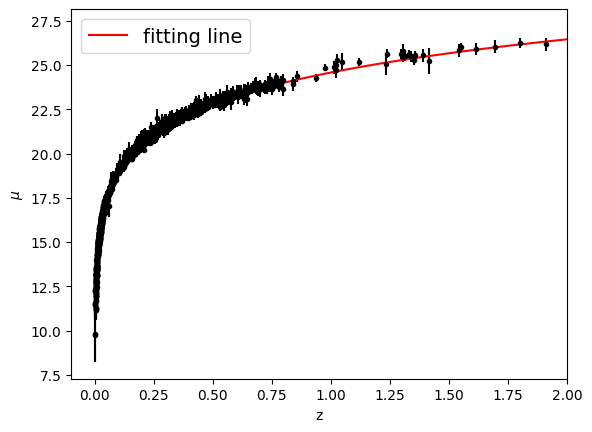

In [21]:
def modelS(z ,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    modelS=5*np.log10(D_L(z,theta))+25+Mb
    return modelS
    
x0 = np.linspace(0.01, 2, 100)
plt.errorbar(xS, yS, yerrS, fmt=".k", capsize=0)
plt.plot(x0, modelS(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(-.1, 2.0)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.show() 

/tmp/ipykernel_8900/729008176.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(xH, yH, yerrH, fmt=".k", capsize=0, color='b')
/tmp/ipykernel_8900/729008176.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x0, modelH(x0, theta_median), "k", label="Our model",color='r')


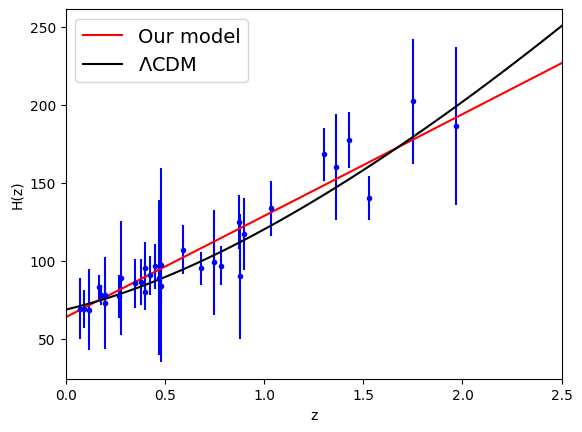

In [22]:
def modelH(z,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    modelH=H(z,theta)
    return modelH  
    
x0 = np.linspace(0, 2.5, 100)
plt.errorbar(xH, yH, yerrH, fmt=".k", capsize=0, color='b')
plt.plot(x0, modelH(x0, theta_median), "k", label="Our model",color='r')
plt.plot(x0, H_LCDM(x0), "k", label=r'$\Lambda \text{CDM}$ ')
plt.legend(fontsize=14)
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.show()

/tmp/ipykernel_8900/3495401944.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x0, modelB(x0, theta_median), "k", label="fitting line",color='r')


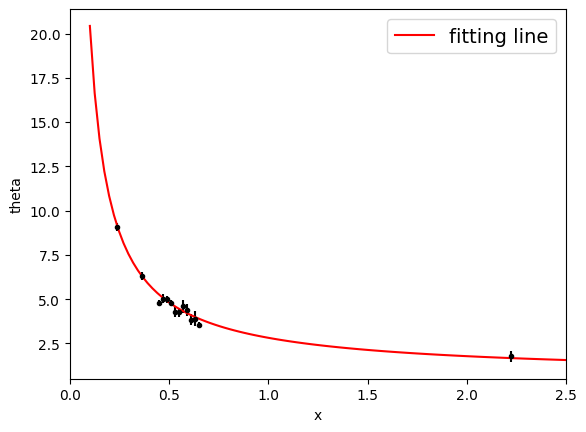

In [23]:
def modelB(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    D_A=D_L(z,theta)/(1+z)
    modelB=100*1.6*180/np.pi/D_A
    return modelB   
    
x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(xB, yB, yerrB, fmt=".k", capsize=0)
plt.plot(x0, modelB(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("x")
plt.ylabel("theta")
plt.show()

/tmp/ipykernel_8900/3790918940.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x0, model_DV(x0, theta_median), "k", label="fitting line",color='r')
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


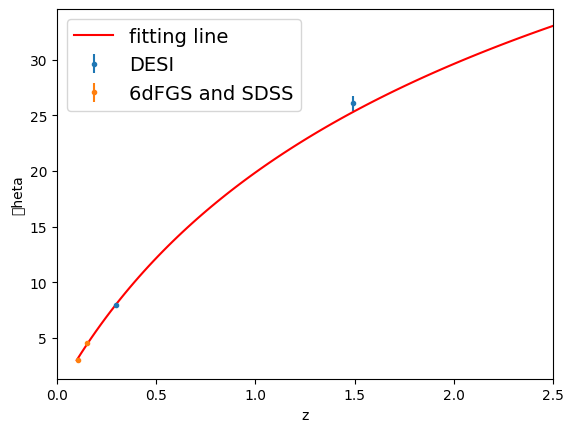

In [24]:
def model_DV(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DV = D_V(z, theta)
    return model_DV

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DV, D_V_obs, sigma_DV, fmt=".", capsize=0, label='DESI')
plt.errorbar(z_DV_SDSS, D_V_obs_SDSS, sigma_DV_SDSS, fmt=".", capsize=0, label='6dFGS and SDSS')
plt.plot(x0, model_DV(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("\theta")
plt.show()

/tmp/ipykernel_8900/894095816.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x0, model_DH(x0, theta_median), "k", label="fitting line",color='r')


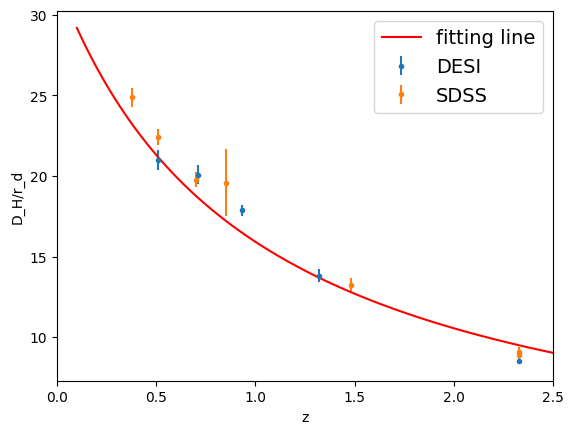

In [25]:
def model_DH(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DH = D_H(z, theta)
    return model_DH

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DH, D_H_obs, sigma_DH, fmt=".", capsize=0, label='DESI')
plt.errorbar(z_DH_SDSS, D_H_obs_SDSS, sigma_DH_SDSS, fmt=".", capsize=0, label='SDSS')
plt.plot(x0, model_DH(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("D_H/r_d")
plt.show()

/tmp/ipykernel_8900/736156473.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x0, model_DM(x0, theta_median), "k", label="fitting line",color='r')


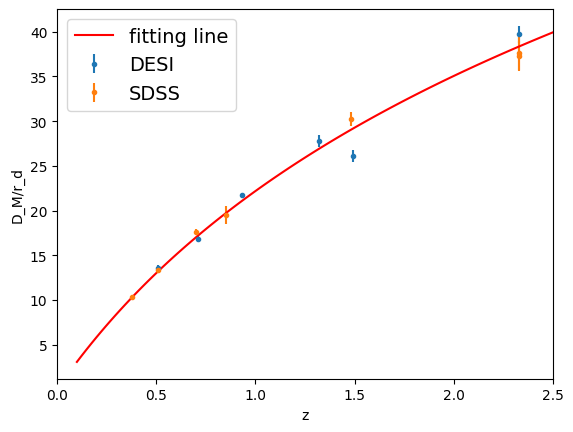

In [26]:
def model_DM(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DM = D_M(z, theta)
    return model_DM

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DM, D_M_obs, sigma_DM, fmt=".", capsize=0,label='DESI')
plt.errorbar(z_DM_SDSS, D_M_obs_SDSS, sigma_DM_SDSS, fmt=".", capsize=0,label='SDSS')
plt.plot(x0, model_DM(x0, theta_median), "k", label="fitting line",color='r')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("D_M/r_d")
plt.show()

In [27]:
log_likelihood_max = log_likelihood(theta_median)
n = 2000
k = ndim  # 模型的自由参数个数
# 计算 AIC 和 BIC
AIC = 2 * k - 2 * log_likelihood_max
BIC = k * np.log(n) - 2 * log_likelihood_max

print(f"AIC: {AIC:.2f}")
print(f"BIC: {BIC:.2f}")

AIC: 2230.17
BIC: 2269.38


# Joint plot

In [28]:
# FQ barrow
# 定义哈勃参数 H(z)
def H2(z, theta):
    H0, c, m, wde, Mb, r_d = theta
    return (H0*(1+z)**(3/2)-c**2*wde*(-1+(1+z)**(3/2))*m)

def InvEz2(z, theta):
    H0, c, m, wde, Mb, r_d = theta
    return H0/H2(z, theta)

def InteEz2(z, theta):
    Inte = []
    for zi in z:
        if zi > 0:
            # 直接使用quad进行快速积分
            fArea, _ = integrate.quad(InvEz2, 0, zi, args=(theta))
            Inte.append(fArea)
        else:
            Inte.append(0)
    return np.array(Inte)

def D_L2(z,theta):
    H0, c, m, wde, Mb, r_d = theta
    d_z=(1+z)*c_light/H0*InteEz2(z, theta)
    return d_z

# 定义距离尺度 D_M(z) 和 D_V(z)
def D_M2(z, theta):
    H0, c, m, wde, Mb, r_d =theta
    return D_L2(z,theta)/(1+z)/r_d

def D_V2(z,theta):
    H0, c, m, wde, Mb, r_d =theta
    # 计算D_V(z) = (D_M^2 * z / H(z))^(1/3)
    D_m = D_M2(z, theta)
    H_z = H2(z, theta)
    return ((D_L2(z,theta)/(1+z))**2 *c_light * z / H_z) ** (1/3) / r_d

def D_H2(z, theta):
    H0, c, m, wde, Mb, r_d = theta
    # 计算D_H(z) = c / H(z)
    H_z = H2(z, theta)
    return c_light / H_z / r_d



In [29]:
# LCDM
# 定义哈勃参数 H(z)
def H_LCDM(z, theta):
    H0, Omega_m, Mb, r_d = theta
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + (1-Omega_m))

def InvEz_LCDM(z, theta):
    H0, Omega_m, Mb, r_d = theta
    return H0/H_LCDM(z, theta)

def InteEz_LCDM(z, theta):
    Inte = []
    for zi in z:
        if zi > 0:
            # 直接使用quad进行快速积分
            fArea, _ = integrate.quad(InvEz_LCDM, 0, zi, args=(theta))
            Inte.append(fArea)
        else:
            Inte.append(0)
    return np.array(Inte)

def D_L_LCDM(z,theta):
    H0, Omega_m, Mb, r_d = theta
    d_z=(1+z)*c_light/H0*InteEz_LCDM(z, theta)
    return d_z



# 定义距离尺度 D_M(z) 和 D_V(z)
def D_M_LCDM(z, theta):
    H0, Omega_m, Mb, r_d =theta
    return D_L_LCDM(z,theta)/(1+z)/r_d

def D_V_LCDM(z,theta):
    H0, Omega_m, Mb, r_d =theta
    # 计算D_V(z) = (D_M^2 * z / H(z))^(1/3)
    D_m = D_M_LCDM(z, theta)
    H_z = H_LCDM(z, theta)
    return ((D_L_LCDM(z,theta)/(1+z))**2 *c_light * z / H_z) ** (1/3) / r_d

def D_H_LCDM(z, theta):
    H0, Omega_m, Mb, r_d = theta
    # 计算D_H(z) = c / H(z)
    H_z = H_LCDM(z, theta)
    return c_light / H_z / r_d



In [30]:
# model2_theta_fQT=[70,-0.5,1,20,-0.5,-19,150]
# model2_theta_fQ=[70,-0.5,0,20,-0.5,-19,150]
model1_theta_fQT=theta_median
model1_theta_fQ=[np.float64(66.49160710919055), np.float64(-6.474347712001189), np.float64(-1.3990803452769816), np.float64(-0.6649285876689536), np.float64(-19.421706834813612), np.float64(146.0597907319653)]
theta_LCDM=[np.float64(67.84484914150798), np.float64(0.32699599690594766), np.float64(-19.412722337825915), np.float64(147.2083740156266)]

/tmp/ipykernel_8900/4102861684.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(xH, yH, yerrH, fmt=".k", capsize=0, color='b')


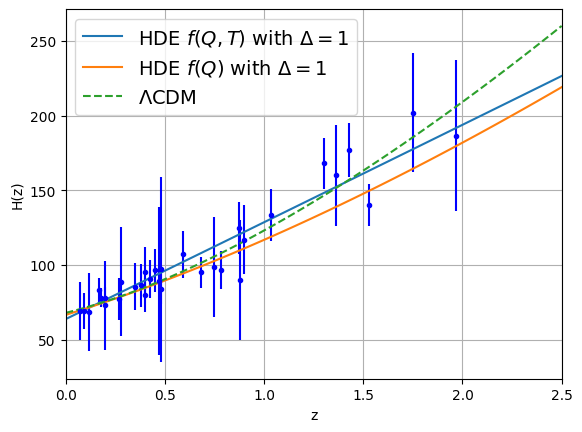

In [31]:
x0 = np.linspace(0, 2.5, 100)
plt.errorbar(xH, yH, yerrH, fmt=".k", capsize=0, color='b')
plt.plot(x0, H(x0, model1_theta_fQT),  label="HDE $f(Q,T)$ with $\Delta=1$")
plt.plot(x0, H2(x0, model1_theta_fQ), label="HDE $f(Q)$ with $\Delta=1$")
plt.plot(x0, H_LCDM(x0,theta_LCDM),label=r'$\Lambda \text{CDM}$',linestyle='--')
# plt.plot(x0, H2(x0, model2_theta_fQ), label="HDE $f(Q)$")
# plt.plot(x0, H2(x0, model2_theta_fQT), label="HDE $f(Q,T)$")
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.grid(True)
plt.savefig('./pic/H-z_relation.pdf', format='pdf')
plt.show()

/tmp/ipykernel_8900/2783934246.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(xS, yS, yerrS, fmt=".k", capsize=0,color='b', ms=2,elinewidth=0.5)


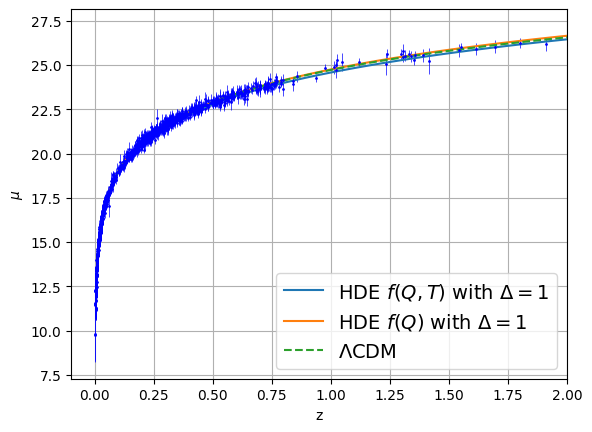

In [32]:
def modelS(z ,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    modelS=5*np.log10(D_L(z,theta))+25+Mb
    return modelS
def modelS2(z ,theta):
    H0, c, m, wde, Mb, r_d = theta
    modelS=5*np.log10(D_L2(z,theta))+25+Mb
    return modelS
def modelS_LCDM(z ,theta):
    H0, Omega_m, Mb, r_d = theta
    modelS=5*np.log10(D_L_LCDM(z,theta))+25+Mb
    return modelS
    
x0 = np.linspace(0.01, 2, 100)
plt.errorbar(xS, yS, yerrS, fmt=".k", capsize=0,color='b', ms=2,elinewidth=0.5)
plt.plot(x0, modelS(x0, model1_theta_fQT), label="HDE $f(Q,T)$ with $\Delta=1$")
plt.plot(x0, modelS2(x0, model1_theta_fQ), label="HDE $f(Q)$ with $\Delta=1$")
plt.plot(x0, modelS_LCDM(x0, theta_LCDM), label=r'$\Lambda \text{CDM}$',linestyle='--')
plt.legend(fontsize=14)
plt.grid(True)
plt.xlim(-.1, 2.0)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.savefig('./pic/mu-z_relation.pdf', format='pdf')
plt.show() 

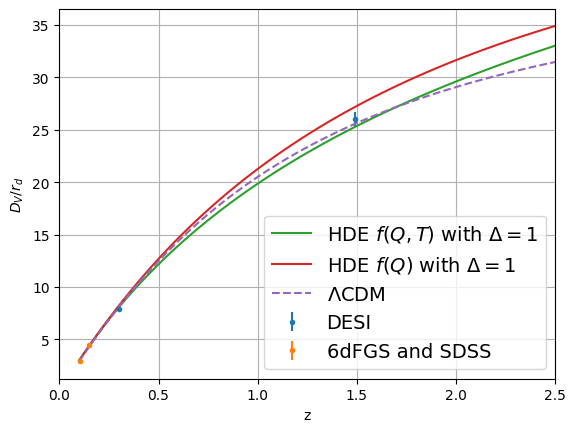

In [33]:
def model_DV(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DV = D_V(z, theta)
    return model_DV
def model_DV2(z, theta):
    H0, c, m, wde, Mb, r_d = theta
    model_DV = D_V2(z, theta)
    return model_DV
def model_DV_LCDM(z, theta):
    H0, Omega_m, Mb, r_d = theta
    model_DV = D_V_LCDM(z, theta)
    return model_DV

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DV, D_V_obs, sigma_DV, fmt=".", capsize=0, label='DESI')
plt.errorbar(z_DV_SDSS, D_V_obs_SDSS, sigma_DV_SDSS, fmt=".", capsize=0, label='6dFGS and SDSS')
plt.plot(x0, model_DV(x0, model1_theta_fQT), label="HDE $f(Q,T)$ with $\Delta=1$")
plt.plot(x0, model_DV2(x0, model1_theta_fQ), label="HDE $f(Q)$ with $\Delta=1$")
plt.plot(x0, model_DV_LCDM(x0, theta_LCDM), label=r'$\Lambda \text{CDM}$',linestyle='--')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("$D_V/r_d$")
plt.grid(True)
plt.savefig('./pic/DV-z_relation.pdf', format='pdf')
plt.show()

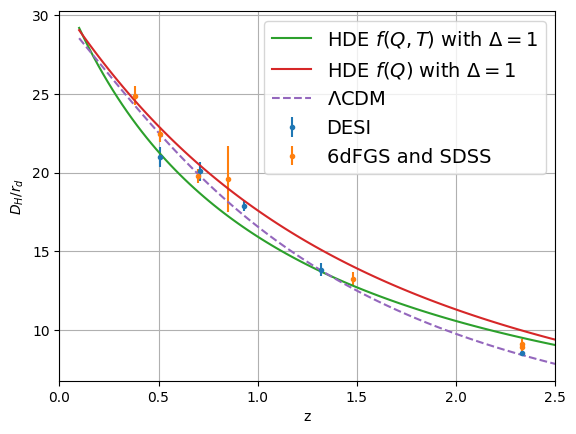

In [34]:
def model_DH(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DH = D_H(z, theta)
    return model_DH
def model_DH2(z, theta):
    H0, c, m, wde, Mb, r_d = theta
    model_DH = D_H2(z, theta)
    return model_DH
def model_DH_LCDM(z, theta):
    H0, Omega_m, Mb, r_d = theta
    model_DH = D_H_LCDM(z, theta)
    return model_DH

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DH, D_H_obs, sigma_DH, fmt=".", capsize=0, label='DESI')
plt.errorbar(z_DH_SDSS, D_H_obs_SDSS, sigma_DH_SDSS, fmt=".", capsize=0, label='6dFGS and SDSS')
plt.plot(x0, model_DH(x0, model1_theta_fQT), label="HDE $f(Q,T)$ with $\Delta=1$")
plt.plot(x0, model_DH2(x0, model1_theta_fQ), label="HDE $f(Q)$ with $\Delta=1$")
plt.plot(x0, model_DH_LCDM(x0, theta_LCDM), label=r'$\Lambda \text{CDM}$',linestyle='--')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("$D_H/r_d$")
plt.grid(True)
plt.savefig('./pic/DH-z_relation.pdf', format='pdf')
plt.show()

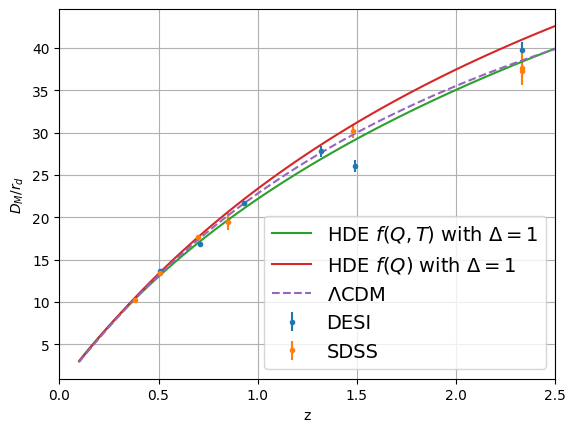

In [35]:
def model_DM(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    model_DM = D_M(z, theta)
    return model_DM
def model_DM2(z, theta):
    H0, c, m, wde, Mb, r_d = theta
    model_DM = D_M2(z, theta)
    return model_DM
def model_DM_LCDM(z, theta):
    H0, Omega_m, Mb, r_d = theta
    model_DM = D_M_LCDM(z, theta)
    return model_DM

x0 = np.linspace(0.1, 2.5, 100)
plt.errorbar(z_DM, D_M_obs, sigma_DM, fmt=".", capsize=0,label='DESI')
plt.errorbar(z_DM_SDSS, D_M_obs_SDSS, sigma_DM_SDSS, fmt=".", capsize=0,label='SDSS')
plt.plot(x0, model_DM(x0, model1_theta_fQT), label="HDE $f(Q,T)$ with $\Delta=1$")
plt.plot(x0, model_DM2(x0, model1_theta_fQ), label="HDE $f(Q)$ with $\Delta=1$")
plt.plot(x0, model_DM_LCDM(x0, theta_LCDM), label=r'$\Lambda \text{CDM}$',linestyle='--')
plt.legend(fontsize=14)
plt.xlim(0, 2.5)
plt.xlabel("z")
plt.ylabel("$D_M/r_d$")
plt.grid(True)
plt.savefig('./pic/DM-z_relation.pdf', format='pdf')
plt.show()

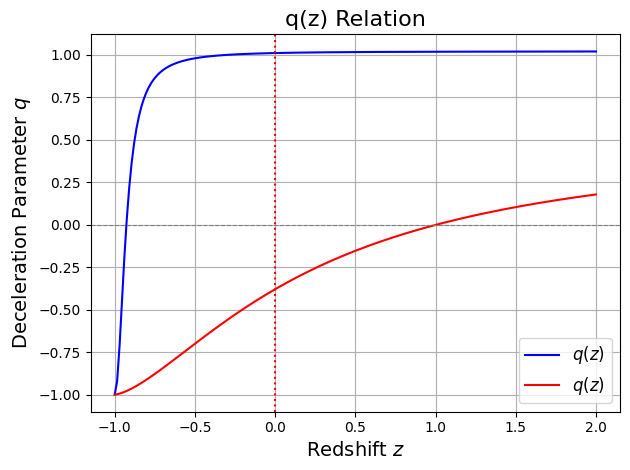

In [36]:
def q_function(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta
    term1 = (z + 1) ** ((3 * (a + 1)) / (3 * a + 2))
    numerator = (2 * a + 1) * c**2 * wde * (3 * a + term1 + 2) - H0 * (1/m) * term1
    denominator = (3 * a + 2) * ((2 * a + 1) * c**2 * wde * (term1 - 1) - H0 * (1/m) * term1)
    return numerator / denominator
def q_function2(z, theta):
    H0, c, m, wde, Mb, r_d = theta
    a=0
    term1 = (z + 1) ** ((3 * (a + 1)) / (3 * a + 2))
    numerator = (2 * a + 1) * c**2 * wde * (3 * a + term1 + 2) - H0 * (1/m) * term1
    denominator = (3 * a + 2) * ((2 * a + 1) * c**2 * wde * (term1 - 1) - H0 * (1/m) * term1)
    return numerator / denominator
x0 = np.linspace(-1, 2, 200)
plt.plot(x0,q_function(x0,model1_theta_fQT), label=r'$q(z)$', color='blue')
plt.plot(x0,q_function2(x0,model1_theta_fQ), label=r'$q(z)$', color='r')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='red', linestyle=':', linewidth=1.5)  # 添加 z = 0 垂直线
plt.xlabel(r'Redshift $z$', fontsize=14)
plt.ylabel(r'Deceleration Parameter $q$', fontsize=14)
plt.title('q(z) Relation', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

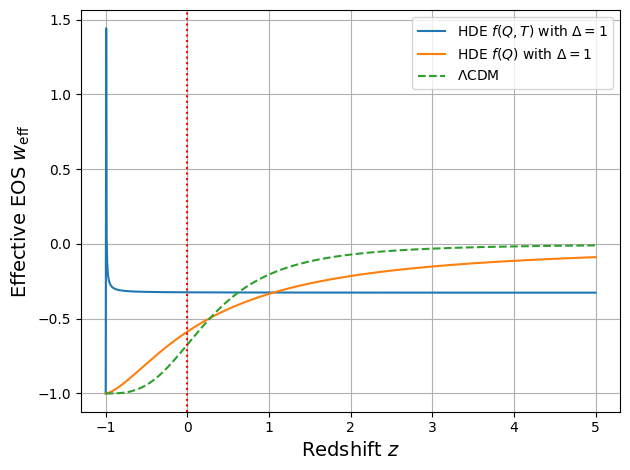

In [37]:
def w_eff(z,theta):
    return -1+2*np.gradient(H(z,theta),z)*(H(z,theta))*(1+z)/(3*H(z,theta)**2)
def w_eff_LCDM(z, theta):
    return -1+2*np.gradient(H_LCDM(z,theta),z)*(H_LCDM(z,theta))*(1+z)/(3*H_LCDM(z,theta)**2)
def w_eff_fQ(z, theta):
    return -1+2*np.gradient(H2(z,theta),z)*(H2(z,theta))*(1+z)/(3*H2(z,theta)**2)
x0 = np.linspace(-1, 5, 1000)
plt.plot(x0,w_eff(x0,model1_theta_fQT), label="HDE $f(Q,T)$ with $\Delta=1$")
plt.plot(x0,w_eff_fQ(x0,model1_theta_fQ),label="HDE $f(Q)$ with $\Delta=1$")
plt.plot(x0,w_eff_LCDM(x0,theta_LCDM), label=r'$\Lambda \text{CDM}$',linestyle='--')
plt.xlabel(r'Redshift $z$', fontsize=14)
plt.ylabel(r'Effective EOS $w_\text{eff}$', fontsize=14)
plt.axvline(0, color='red', linestyle=':', linewidth=1.5)  # 添加 z = 0 垂直线
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./pic/w_eff-z_relation.pdf', format='pdf')
plt.show()

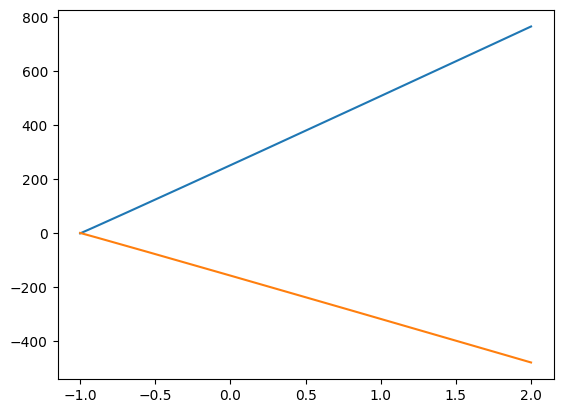

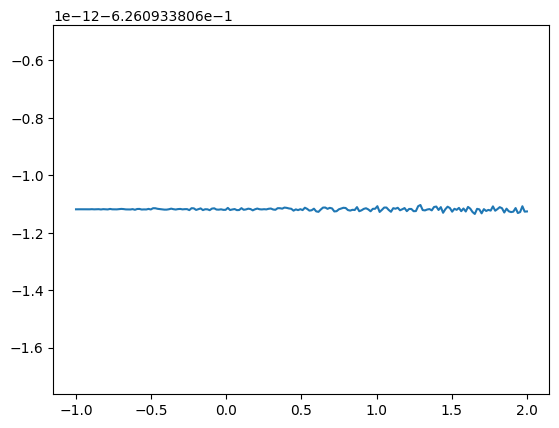

In [38]:
def rde(z,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    return 3*c**2*H(z,theta)
def pde(z,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    return 3*c**2*H(z,theta)*wde
def cs2(z,theta):
    H0, c, a, m, wde, Mb, r_d = theta
    return np.gradient(pde(z,theta),z)/np.gradient(rde(z,theta),z)
x0 = np.linspace(-1, 2, 200)
plt.plot(x0,rde(x0,model1_theta_fQT))
plt.plot(x0,pde(x0,model1_theta_fQT))
plt.show()
plt.plot(x0,cs2(x0,model1_theta_fQT))
plt.show()

In [39]:
def rho_m(z, theta):
    H0, c, a, m, wde, Mb, r_d = theta    
    H_z = H(z,theta)
    dH_z = np.gradient(H_z,z)
    n=1
    # 物质密度的公式
    numerator = (1/m) * (2 * n - 1) * (6 * H_z**2)**(n - 1) * (
        -3 * (1 + wde) * (1 + a) * H_z**2 - 
        n * (1 + z) * (-2 + (-3 + wde) * a) * H_z * dH_z
    )
    denominator = wde * (1 + 3 * a + 2 * a**2)
    
    return numerator / denominator/3/H_z**2


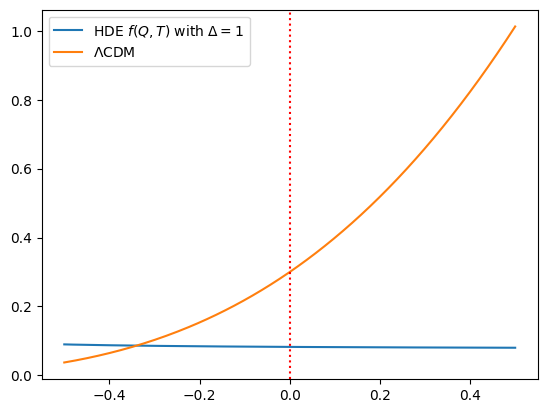

In [40]:
#物质占比
x0 = np.linspace(-0.5, 0.5, 200)
rho_m(x0,model1_theta_fQT)
plt.plot(x0,rho_m(x0,model1_theta_fQT),label="HDE $f(Q,T)$ with $\Delta=1$")
plt.plot(x0,0.3*(1+x0)**3,label=r'$\Lambda \text{CDM}$')
plt.axvline(0, color='red', linestyle=':', linewidth=1.5)  # 添加 z = 0 垂直线
plt.legend()
plt.show()
